In [1]:
import os
import pandas as pd
import numpy as np
import plotly_express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt
import seaborn as sns
# import gc
import warnings
warnings.filterwarnings('ignore')
# from lightgbm import LGBMRegressor
# import joblib

# 1. Import Data

In [2]:
sales = pd.read_csv('./m5-forecasting-accuracy/sales_train_evaluation.csv')
# sales.name = 'sales'
calendar = pd.read_csv('./m5-forecasting-accuracy/calendar.csv')
# calendar.name = 'calendar'
prices = pd.read_csv('./m5-forecasting-accuracy/sell_prices.csv')
# prices.name = 'prices'

In [3]:
#Add zero sales for the remaining days 1942-1969
for d in range(1942,1970):
    col = 'd_' + str(d)
    sales[col] = 0
    sales[col] = sales[col].astype(np.int16)

# 2. Preparing Data
## 2.1 Downcasting

In [4]:
sales_bd = np.round(sales.memory_usage().sum()/(1024*1024),1)
calendar_bd = np.round(calendar.memory_usage().sum()/(1024*1024),1)
prices_bd = np.round(prices.memory_usage().sum()/(1024*1024),1)

In [5]:
#Downcast in order to save memory
def downcast(df):
    cols = df.dtypes.index.tolist()
    types = df.dtypes.values.tolist()
    for i,t in enumerate(types):
        if 'int' in str(t):
            if df[cols[i]].min() > np.iinfo(np.int8).min and df[cols[i]].max() < np.iinfo(np.int8).max:
                df[cols[i]] = df[cols[i]].astype(np.int8)
            elif df[cols[i]].min() > np.iinfo(np.int16).min and df[cols[i]].max() < np.iinfo(np.int16).max:
                df[cols[i]] = df[cols[i]].astype(np.int16)
            elif df[cols[i]].min() > np.iinfo(np.int32).min and df[cols[i]].max() < np.iinfo(np.int32).max:
                df[cols[i]] = df[cols[i]].astype(np.int32)
            else:
                df[cols[i]] = df[cols[i]].astype(np.int64)
        elif 'float' in str(t):
            if df[cols[i]].min() > np.finfo(np.float16).min and df[cols[i]].max() < np.finfo(np.float16).max:
                df[cols[i]] = df[cols[i]].astype(np.float16)
            elif df[cols[i]].min() > np.finfo(np.float32).min and df[cols[i]].max() < np.finfo(np.float32).max:
                df[cols[i]] = df[cols[i]].astype(np.float32)
            else:
                df[cols[i]] = df[cols[i]].astype(np.float64)
        elif t == np.object:
            if cols[i] == 'date':
                df[cols[i]] = pd.to_datetime(df[cols[i]], format='%Y-%m-%d')
            else:
                df[cols[i]] = df[cols[i]].astype('category')
    return df  

sales = downcast(sales)
prices = downcast(prices)
calendar = downcast(calendar)

In [6]:
sales_ad = np.round(sales.memory_usage().sum()/(1024*1024),1)
calendar_ad = np.round(calendar.memory_usage().sum()/(1024*1024),1)
prices_ad = np.round(prices.memory_usage().sum()/(1024*1024),1)

In [7]:
dic = {'DataFrame':['sales','calendar','prices'],
       'Before downcasting':[sales_bd,calendar_bd,prices_bd],
       'After downcasting':[sales_ad,calendar_ad,prices_ad]}

memory = pd.DataFrame(dic)
memory = pd.melt(memory, id_vars='DataFrame', var_name='Status', value_name='Memory (MB)')
memory.sort_values('Memory (MB)',inplace=True)
fig = px.bar(memory, x='DataFrame', y='Memory (MB)', color='Status', barmode='group', text='Memory (MB)')
fig.update_traces(texttemplate='%{text} MB', textposition='outside')
fig.update_layout(template='seaborn', title='Effect of Downcasting')
fig.show()

## 2.2 Melting the data
To make analysis of data in table easier we can reshape the data into a more computer-friendly form using pandas in Python. pandas.melt() function is used to unpivots a DataFrame from wide format to long format.

In [30]:
%%time
df = pd.melt(sales, id_vars=['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'], var_name='d', value_name='sold').dropna()

CPU times: user 1min 34s, sys: 4.97 s, total: 1min 39s
Wall time: 1min 40s


In [31]:
%%time
df = pd.merge(df, calendar, on='d', how='left')
df = pd.merge(df, prices, on=['store_id','item_id','wm_yr_wk'], how='left') 

In [32]:
print(df.shape)
df.head()

(60034810, 22)


id        item_id    dept_id   cat_id store_id  \
0  HOBBIES_1_001_CA_1_evaluation  HOBBIES_1_001  HOBBIES_1  HOBBIES     CA_1   
1  HOBBIES_1_002_CA_1_evaluation  HOBBIES_1_002  HOBBIES_1  HOBBIES     CA_1   
2  HOBBIES_1_003_CA_1_evaluation  HOBBIES_1_003  HOBBIES_1  HOBBIES     CA_1   
3  HOBBIES_1_004_CA_1_evaluation  HOBBIES_1_004  HOBBIES_1  HOBBIES     CA_1   
4  HOBBIES_1_005_CA_1_evaluation  HOBBIES_1_005  HOBBIES_1  HOBBIES     CA_1   

  state_id    d  sold       date  wm_yr_wk  ... month  year  event_name_1  \
0       CA  d_1     0 2011-01-29     11101  ...     1  2011           NaN   
1       CA  d_1     0 2011-01-29     11101  ...     1  2011           NaN   
2       CA  d_1     0 2011-01-29     11101  ...     1  2011           NaN   
3       CA  d_1     0 2011-01-29     11101  ...     1  2011           NaN   
4       CA  d_1     0 2011-01-29     11101  ...     1  2011           NaN   

   event_type_1 event_name_2 event_type_2 snap_CA snap_TX  snap_WI  sell_price  
0           NaN          NaN          NaN       0       0        0         NaN  
1           NaN          NaN          NaN       0       0        0         NaN  
2           NaN          NaN          NaN       0       0        0         NaN  
3           NaN          NaN          NaN       0       0        0         NaN  
4           NaN          NaN          NaN       0       0        0         NaN  

[5 rows x 22 columns]

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 60034810 entries, 0 to 60034809
Data columns (total 22 columns):
 #   Column        Dtype         
---  ------        -----         
 0   id            category      
 1   item_id       category      
 2   dept_id       category      
 3   cat_id        category      
 4   store_id      category      
 5   state_id      category      
 6   d             object        
 7   sold          int16         
 8   date          datetime64[ns]
 9   wm_yr_wk      int16         
 10  weekday       category      
 11  wday          int8          
 12  month         int8          
 13  year          int16         
 14  event_name_1  category      
 15  event_type_1  category      
 16  event_name_2  category      
 17  event_type_2  category      
 18  snap_CA       int8          
 19  snap_TX       int8          
 20  snap_WI       int8          
 21  sell_price    float16       
dtypes: category(11), datetime64[ns](1), float16(1), int16(3), int8(5

In [36]:
df.isna().sum()

id                     0
item_id                0
dept_id                0
cat_id                 0
store_id               0
state_id               0
d                      0
sold                   0
date                   0
wm_yr_wk               0
weekday                0
wday                   0
month                  0
year                   0
event_name_1    55095430
event_type_1    55095430
event_name_2    59882360
event_type_2    59882360
snap_CA                0
snap_TX                0
snap_WI                0
sell_price      12299413
dtype: int64

# 3. Exploratory Data Analysis

In [51]:
def patch1(bar,ax):
  #https://stackoverflow.com/questions/52080991/display-percentage-above-bar-chart-in-matplotlib
  for p in bar.patches: 
     width=p.get_width()
     height=p.get_height()
     x,y=p.get_xy() 
     ax.annotate('{}%'.format(height),(x+width/2,y+height*1.02),ha='center',fontsize=14, color='white')

In [52]:
def patch2(a,ax):
  #https://stackoverflow.com/questions/52080991/display-percentage-above-bar-chart-in-matplotlib
  for p in a.patches:  
    width=p.get_width()
    height=p.get_height()
    x,y=p.get_xy() 
    ax.annotate('{:.2f}'.format(height),(x+width/2,y+height*1.02),ha='center',fontsize=13, color='white')

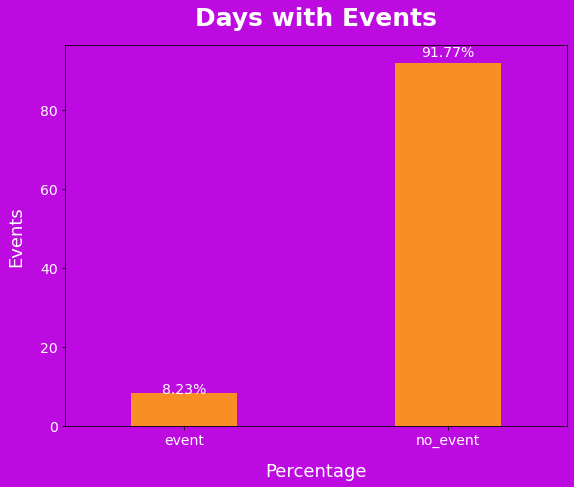

In [53]:
l=[]
l=np.unique(calendar[calendar['event_type_1'].notnull()]['d'].tolist()) 
df_temp=pd.DataFrame([["event",np.round((len(l)/calendar.shape[0]*100),2)],["no_event",100-np.round((len(l)/calendar.shape[0]*100),2)]],columns=['Events','Percentage'])
fig,axes=plt.subplots(figsize=(9,7))
a=df_temp.plot(kind='bar',y='Percentage',x='Events',width=0.4,ax=axes,color='#f98f24')      
patch1(a,axes)                                                                      
plt.title('Days with Events',loc='center',fontsize=25,pad='20',fontweight='bold', color='white')
axes.set_xlabel('Percentage',fontsize=18,labelpad=15, color='white')
axes.set_ylabel('Events',fontsize=18,labelpad=15, color='white')
plt.xticks(rotation='horizontal',fontsize=14, color='white')
plt.yticks(fontsize=14, color='white')
axes.get_legend().remove()
axes.set_facecolor("#BD0AE0")
fig.set_facecolor("#BD0AE0")
plt.show() 

In [61]:
d=df[['year','date','state_id','store_id', 'sold','sell_price']].dropna()
d['revenue'] = d.sold * d.sell_price
group = d.groupby(['year','date','state_id','store_id'], as_index=False)['revenue'].sum().dropna()

fig = go.Figure()
title = 'Revenue over time'
years = group.year.unique().tolist()
buttons = []
y=3
for state in group.state_id.unique().tolist():
    group_state = group[group['state_id']==state]
    for store in group_state.store_id.unique().tolist():
        group_state_store = group_state[group_state['store_id']==store]
        fig.add_trace(go.Scatter(name=store, x=group_state_store['date'], y=group_state_store['revenue'], showlegend=True, 
                                   yaxis='y'+str(y) if y!=1 else 'y'))
    y-=1

fig.update_layout(
        xaxis=dict(
        #autorange=True,
        range = ['2011-01-29','2016-05-22'],
        rangeselector=dict(
            buttons=list([
                dict(count=1,
                     label="1m",
                     step="month",
                     stepmode="backward"),
                dict(count=6,
                     label="6m",
                     step="month",
                     stepmode="backward"),
                dict(count=1,
                     label="YTD",
                     step="year",
                     stepmode="todate"),
                dict(count=1,
                     label="1y",
                     step="year",
                     stepmode="backward"),
                dict(count=2,
                     label="2y",
                     step="year",
                     stepmode="backward"),
                dict(count=3,
                     label="3y",
                     step="year",
                     stepmode="backward"),
                dict(count=4,
                     label="4y",
                     step="year",
                     stepmode="backward"),
                dict(step="all")
            ])
        ),
        rangeslider=dict(
            autorange=True,
        ),
        type="date"
    ),
    yaxis=dict(
        anchor="x",
        autorange=True,
        domain=[0, 0.33],
        mirror=True,
        showline=True,
        side="left",
        tickfont={"size":10},
        tickmode="auto",
        ticks="",
        title='WI',
        titlefont={"size":20},
        type="linear",
        zeroline=False
    ),
    yaxis2=dict(
        anchor="x",
        autorange=True,
        domain=[0.33, 0.66],
        mirror=True,
        showline=True,
        side="left",
        tickfont={"size":10},
        tickmode="auto",
        ticks="",
        title = 'TX',
        titlefont={"size":20},
        type="linear",
        zeroline=False
    ),
    yaxis3=dict(
        anchor="x",
        autorange=True,
        domain=[0.66, 1],
        mirror=True,
        showline=True,
        side="left",
        tickfont={"size":10},
        tickmode="auto",
        ticks='',
        title="CA",
        titlefont={"size":20},
        type="linear",
        zeroline=False
    )
    )
fig.update_layout(template='seaborn', title=title)
fig.show()

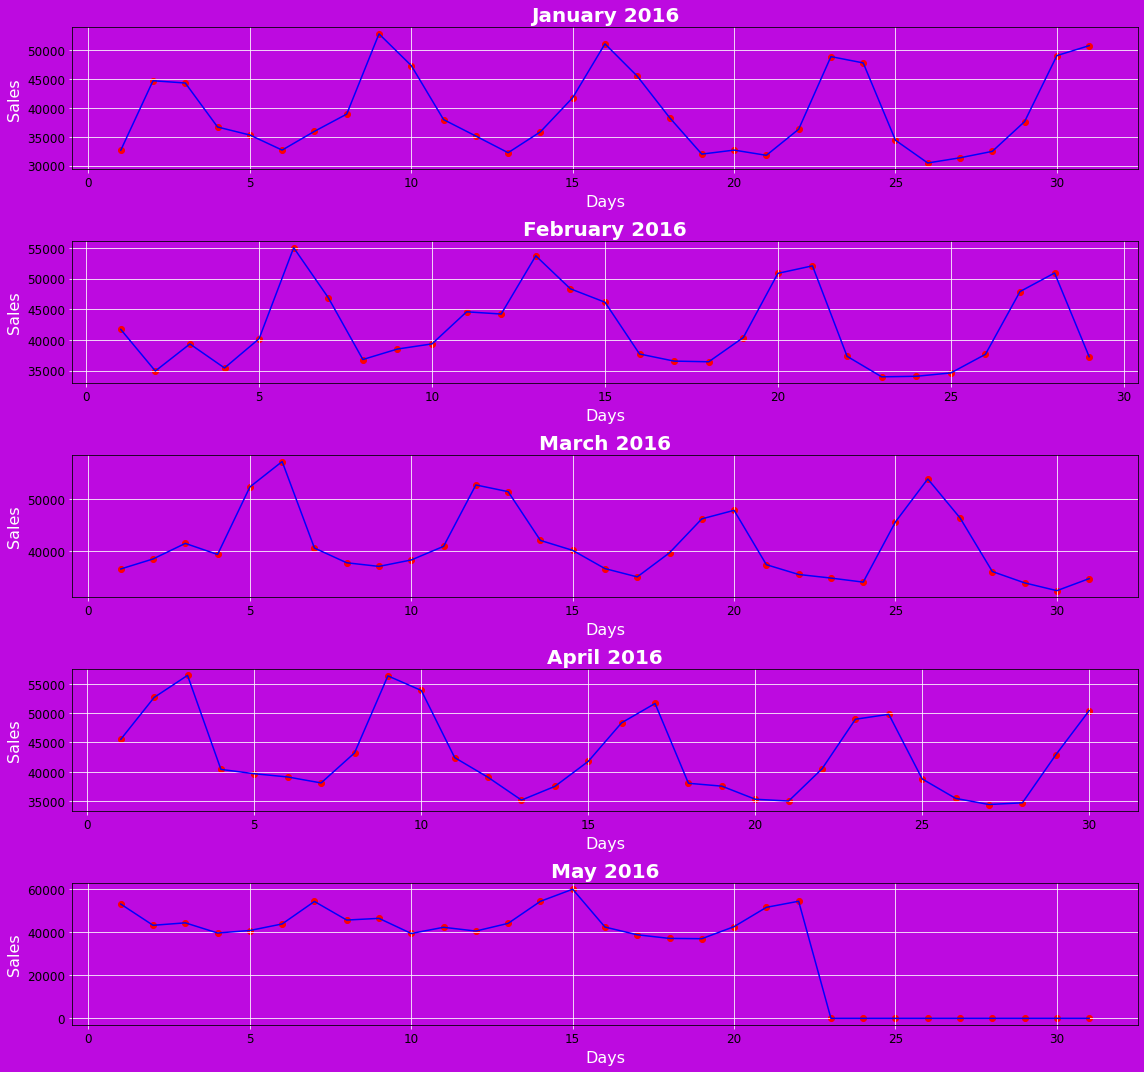

In [81]:
df_temp = df.copy()
df_temp["day"]=df_temp["date"].apply(lambda date: date.day)

d=df_temp[['year','month','day','sold']]

m=[1,2,3,4,5]
m_=['January','February','March','April','May']
fig=plt.figure(figsize=(16,15))
for i in range(len(m)):
  e=d.loc[d['year']==2016]
  e=e.loc[e['month']==m[i]]
  e=e[['day','sold']]
  e=e.groupby('day').sum().reset_index() 
  ax=plt.subplot(5,1,i+1)
  ax.set_title(m_[i]+' 2016',fontsize=20,fontweight='bold', color ="white")
  ax.scatter(e['day'].tolist(),e['sold'].tolist(),color='r',zorder=1)
  ax.plot(e['day'].tolist(),e['sold'].tolist(),color='b',zorder=2)
  ax.tick_params(axis='both',labelsize=12,color ="white")
  ax.set_ylabel('Sales',fontsize=16,labelpad=5,color ="white")
  ax.set_xlabel('Days',fontsize=16,labelpad=5,color ="white")
  ax.grid(True,color ="white")
  ax.set_facecolor("#BD0AE0")
  fig.set_facecolor("#BD0AE0")
plt.tight_layout()
plt.show()

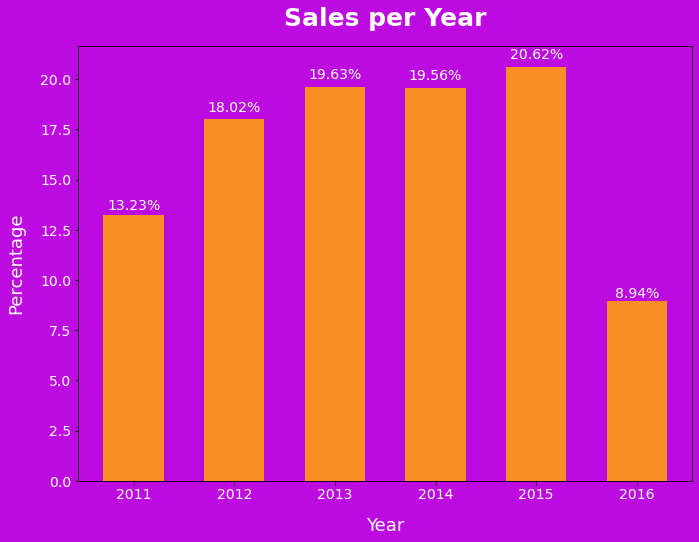

In [56]:
d=df[['year','sold']]
d=d.groupby(by='year').sum().reset_index()
d['percent']=np.round(d['sold']/d['sold'].sum()*100,2)
d=d.sort_values('year')
fig,axes=plt.subplots(figsize=(11,8))
a=d.plot(kind='bar',x='year',y='percent',width=0.6,ax=axes, color='#f98f24')
patch1(a,axes)
plt.title('Sales per Year',loc='center',fontsize=25,pad='20',fontweight='bold', color='white')
axes.set_ylabel('Percentage',fontsize=18,labelpad=15, color='white')
axes.set_xlabel('Year',fontsize=18,labelpad=15, color='white')
plt.xticks(rotation='horizontal',fontsize=14, color='white')
plt.yticks(fontsize=14, color='white')
axes.get_legend().remove()
axes.set_facecolor("#BD0AE0")
fig.set_facecolor("#BD0AE0")
plt.show() 

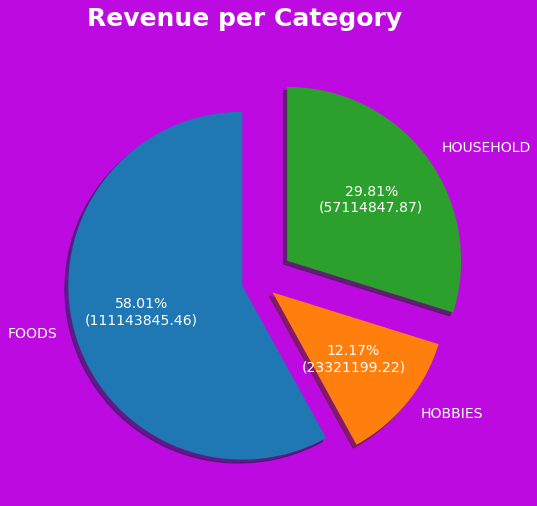

In [59]:
#https://www.askpython.com/python/plot-customize-pie-chart-in-python
def func(v,p): #https://stackoverflow.com/questions/6170246/how-do-i-use-matplotlib-autopct
  a=p*sum(v)/100
  return "{:.2f}%\n({:.2f})".format(p,a)
d=df[['cat_id','sold','sell_price']].dropna()
d['revenue'] = d.sold * d.sell_price
cat=['FOODS','HOBBIES','HOUSEHOLD']
l=[]
for i in cat:
  s=[]
  s=d[d['cat_id']==i]['revenue'].tolist()
  l.append(np.round(sum(s),2))
d=pd.DataFrame(columns=['cat','revenue'])
d['cat']=cat
d['revenue']=l
fig,ax=plt.subplots(figsize=(16,8))
e=(0.1,0.1,0.2) 
ax.pie(d['revenue'],explode=e,labels=d['cat'],shadow=True,startangle=90,autopct=lambda p: func(d['revenue'].tolist(),p),textprops={'fontsize': 14, 'color':'white'})
fig.suptitle('Revenue per Category',fontsize=25,fontweight='bold', color='white')
fig.set_facecolor("#BD0AE0")
plt.show()

# 4. Feature Engineering

## 4.1 Label Encoding

In [82]:
#Store the categories along with their codes
d_id = dict(zip(df.id.cat.codes, df.id))
d_item_id = dict(zip(df.item_id.cat.codes, df.item_id))
d_dept_id = dict(zip(df.dept_id.cat.codes, df.dept_id))
d_cat_id = dict(zip(df.cat_id.cat.codes, df.cat_id))
d_store_id = dict(zip(df.store_id.cat.codes, df.store_id))
d_state_id = dict(zip(df.state_id.cat.codes, df.state_id))

In [85]:
df.d = df['d'].apply(lambda x: x.split('_')[1]).astype(np.int16)
cols = df.dtypes.index.tolist()
types = df.dtypes.values.tolist()
for i,type in enumerate(types):
    if type.name == 'category':
        df[cols[i]] = df[cols[i]].cat.codes
        
df.drop('date',axis=1,inplace=True)

## 4.2 Lags

In [86]:
#Introduce lags
lags = [1,2,3,6,12,24,36]
for lag in lags:
    df['sold_lag_'+str(lag)] = df.groupby(['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'],as_index=False)['sold'].shift(lag).astype(np.float16)

## 4.3 Mean Encoding

In [87]:
df['iteam_sold_avg'] = df.groupby('item_id')['sold'].transform('mean').astype(np.float16)
df['state_sold_avg'] = df.groupby('state_id')['sold'].transform('mean').astype(np.float16)
df['store_sold_avg'] = df.groupby('store_id')['sold'].transform('mean').astype(np.float16)
df['cat_sold_avg'] = df.groupby('cat_id')['sold'].transform('mean').astype(np.float16)
df['dept_sold_avg'] = df.groupby('dept_id')['sold'].transform('mean').astype(np.float16)
df['cat_dept_sold_avg'] = df.groupby(['cat_id','dept_id'])['sold'].transform('mean').astype(np.float16)
df['store_item_sold_avg'] = df.groupby(['store_id','item_id'])['sold'].transform('mean').astype(np.float16)
df['cat_item_sold_avg'] = df.groupby(['cat_id','item_id'])['sold'].transform('mean').astype(np.float16)
df['dept_item_sold_avg'] = df.groupby(['dept_id','item_id'])['sold'].transform('mean').astype(np.float16)
df['state_store_sold_avg'] = df.groupby(['state_id','store_id'])['sold'].transform('mean').astype(np.float16)
df['state_store_cat_sold_avg'] = df.groupby(['state_id','store_id','cat_id'])['sold'].transform('mean').astype(np.float16)
df['store_cat_dept_sold_avg'] = df.groupby(['store_id','cat_id','dept_id'])['sold'].transform('mean').astype(np.float16)

## 4.4 Rolling Window Statistics

In [88]:
df['rolling_sold_mean'] = df.groupby(['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'])['sold'].transform(lambda x: x.rolling(window=7).mean()).astype(np.float16)

## 4.5 Expanding Window Statistics

In [90]:
df['expanding_sold_mean'] = df.groupby(['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'])['sold'].transform(lambda x: x.expanding(2).mean()).astype(np.float16)

## 4.6 Trends

In [91]:
df['daily_avg_sold'] = df.groupby(['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id','d'])['sold'].transform('mean').astype(np.float16)
df['avg_sold'] = df.groupby(['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'])['sold'].transform('mean').astype(np.float16)
df['selling_trend'] = (df['daily_avg_sold'] - df['avg_sold']).astype(np.float16)
df.drop(['daily_avg_sold','avg_sold'],axis=1,inplace=True)

# Save Data

In [92]:
df = df[df['d']>=36]
df.to_pickle('data.pkl')

#### Most of source code I borrow from this two great notebook
- https://www.kaggle.com/c/m5-forecasting-accuracy/discussion/163916
- https://www.kaggle.com/anshuls235/time-series-forecasting-eda-fe-modelling